# Imports

In [20]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense, LSTM

# For reading stock data from yahoo
import yfinance as yf

# For time stamps
from datetime import datetime

# Load source data

In [6]:
# The tech stocks we'll use for this analysis
# tech_list = ['^GSPC', '^IXIC', '^GDAXI', '^DJI', 'CL=F', 'GC=F', '^CMC200']


# Get the stock quote
df = yf.download('^GSPC','2018-01-01','2023-01-01')
# Show teh data
df.head(2)

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-01-02 00:00:00-05:00,2683.729980,2695.889893,2682.360107,2695.810059,2695.810059,3397430000
2018-01-03 00:00:00-05:00,2697.850098,2714.370117,2697.770020,2713.060059,2713.060059,3544030000


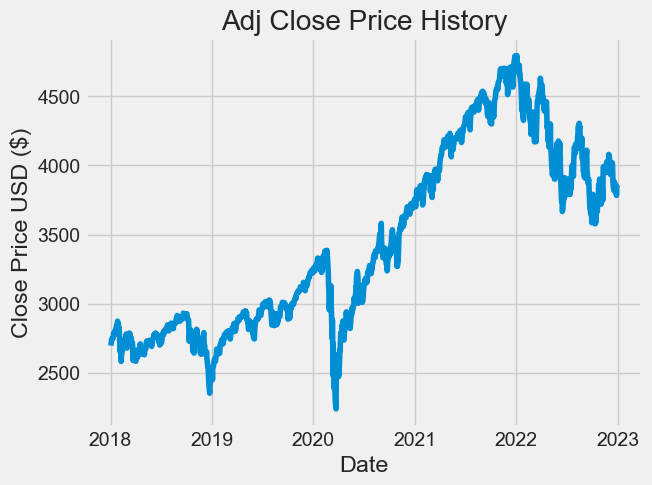

In [8]:
# plt.figure(figsize=(16,6))
plt.title('Adj Close Price History')
plt.plot(df['Adj Close'])
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.show()

# Train test split

In [41]:
# Create a new dataframe with only the 'Adj Close' column 
data = df.filter(['Adj Close'])
# Convert the dataframe to a numpy array
dataset = data.values
# Get the number of rows to train the model on

# training_data_len = int(np.ceil( len(dataset) * .95 ))
training_data_len = df[df.index.year < 2022].shape[0]


In [42]:
# Scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)


In [43]:
# Create the training data set 
# Create the scaled training data set
train_data = scaled_data[0:int(training_data_len), :]
# Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
        
# Convert the x_train and y_train to numpy arrays 
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
# x_train.shape

# Build model

In [44]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

2023-01-29 19:21:02.066646: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-29 19:21:02.278303: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-29 19:21:02.366635: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-29 19:21:02.473569: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  1/948 [..............................] - ETA: 22:42 - loss: 0.2056

2023-01-29 19:21:02.649719: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


948/948 [==============================] - 30s 30ms/step - loss: 0.0022


In [45]:
# Create the testing data set
# Create a new array containing scaled values from index 1543 to 2002 
test_data = scaled_data[training_data_len - 60: , :]
# Create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])
    
# Convert the data to a numpy array
x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

# Get the models predicted price values 
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))

2023-01-29 19:21:31.347663: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-29 19:21:31.435727: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-29 19:21:31.523021: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


8/8 [==============================] - 1s 33ms/step


In [46]:
valid = data[training_data_len:]
valid['Predictions'] = predictions

/var/folders/lk/6f78t4jn60s5_ntqqc2dj0980000gn/T/ipykernel_16448/564130508.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


In [69]:
vd = valid.diff()
vd.rename(columns={'Adj Close': 'Adj Close diff', 'Predictions': 'Predictions diff'}, inplace=True)
res = pd.concat([valid, vd], axis=1)
res = res[['Adj Close diff', 'Predictions diff']].apply(lambda x: x > 0)
res.rename(columns={'Adj Close diff': 'Adj Close Down', 'Predictions diff': 'Predictions Down'}, inplace=True)
res.head()

,Adj Close Down,Predictions Down
Date,,
2022-01-03 00:00:00-05:00,False,False
2022-01-04 00:00:00-05:00,False,True
2022-01-05 00:00:00-05:00,False,True
2022-01-06 00:00:00-05:00,False,False
2022-01-07 00:00:00-05:00,False,False


In [61]:
res.loc[res['Adj Close Down'] == res['Predictions Down']].value_counts().sum() / res.shape[0]

0.4940239043824701

In [64]:
res.loc[res['Predictions Down'] == False].value_counts()

Adj Close Down  Predictions Down
False           False               78
True            False               61
dtype: int64

/var/folders/lk/6f78t4jn60s5_ntqqc2dj0980000gn/T/ipykernel_16448/4033288825.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


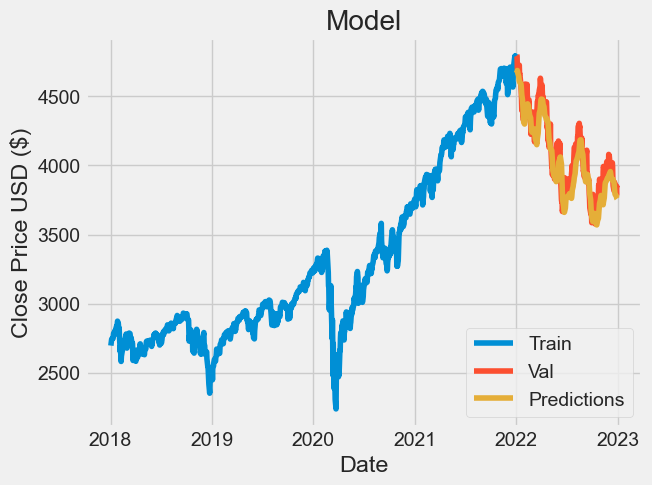

In [68]:
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
# Visualize the data
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(train['Adj Close'])
plt.plot(valid[['Adj Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()